# Task 1

1. ¿Cómo afecta la elección de la estrategia de exploración (exploring starts vs soft policy) a la precisión de la evaluación de políticas en los métodos de Monte Carlo?
- Considere la posibilidad de comparar el desempeño de las políticas evaluadas con y sin explorar los inicios o con diferentes niveles de exploración en políticas blandas.

La elección entre exploring starts y soft policy influye significativamente en la precisión de la evaluación de políticas en los métodos de Monte Carlo. Exploring starts garantiza que todos los estados y acciones sean explorados al menos una vez, lo que permite una cobertura más completa del espacio de decisiones. Esto resulta en estimaciones más precisas del valor de las políticas, especialmente en entornos donde ciertas acciones podrían no ser seleccionadas naturalmente bajo una política determinada. Sin embargo, este enfoque puede ser poco práctico en escenarios reales, ya que requiere control total sobre el estado inicial y la acción inicial, lo cual no siempre es factible.

Por otro lado, las soft policies, como las estrategias ε-greedy, introducen aleatoriedad en la selección de acciones, permitiendo que se exploren acciones subóptimas con cierta probabilidad. Esto mejora la cobertura del espacio de estados y acciones sin necesidad de manipular directamente los inicios, lo que las hace más aplicables en entornos reales. No obstante, el nivel de exploración debe ser cuidadosamente ajustado: una política demasiado blanda puede ralentizar la convergencia al introducir ruido excesivo, mientras que una política demasiado rígida puede limitar la exploración y sesgar la evaluación. En resumen, ambas estrategias buscan mejorar la precisión de la evaluación, pero lo hacen con diferentes compromisos entre control, aplicabilidad y eficiencia

2. En el contexto del aprendizaje de Monte Carlo fuera de la póliza, ¿cómo afecta la razón de muestreo de importancia a la convergencia de la evaluación de políticas? Explore cómo la razón de muestreo de importancia afecta la estabilidad y la convergencia.

En el aprendizaje de Monte Carlo off-policy, la razón de muestreo de importancia ajusta las estimaciones de valor para compensar la diferencia entre la política de comportamiento y la política objetivo, permitiendo evaluar esta última con datos generados por la primera. Aunque es fundamental para la validez del enfoque off-policy, su uso puede introducir alta varianza cuando las políticas difieren significativamente, lo que afecta negativamente la estabilidad y la convergencia del aprendizaje. Para contrarrestar esto, se emplean técnicas como el muestreo de importancia ponderado, que reduce la varianza a costa de introducir sesgo, mejorando la estabilidad general. En conjunto, el impacto de la razón de muestreo depende de la proximidad entre las políticas y del método de ajuste utilizado, siendo clave para lograr una evaluación precisa y eficiente


3. ¿Cómo puede el uso de una soft policy influir en la eficacia del aprendizaje de políticas óptimas en comparación con las políticas deterministas en los métodos de Monte Carlo? Compare el desempeño y los resultados de aprendizaje de las políticas derivadas de estrategias ε-greedy con las derivadas de políticas deterministas.

Las *soft policies*, como *ε-greedy*, mejoran el aprendizaje en Monte Carlo al permitir exploración continua, evitando que el agente se estanque en decisiones subóptimas. A diferencia de las políticas deterministas, fomentan la búsqueda de mejores acciones a largo plazo, lo que puede acelerar la convergencia hacia una política óptima. Sin embargo, si la exploración es excesiva, puede introducir ruido y ralentizar el proceso.


4. ¿Cuáles son los posibles beneficios y desventajas de utilizar métodos de Monte Carlo off-policy en comparación con los on-policy en términos de eficiencia de la muestra, costo computacional, y velocidad de aprendizaje?


Los métodos de Monte Carlo *off-policy* ofrecen mayor flexibilidad al permitir el uso de datos generados por distintas políticas, lo que mejora la eficiencia de muestra y facilita el reaprovechamiento de experiencias. Sin embargo, esto puede aumentar la varianza y requerir técnicas como el muestreo de importancia, elevando el costo computacional y afectando la estabilidad. En contraste, los métodos *on-policy* suelen ser más estables y directos, pero requieren generar nuevas muestras para cada evaluación, lo que puede ser más lento y menos eficiente en entornos complejos.


# Task 2
En este ejercicio, simulará un sistema de gestión de inventarios para una pequeña tienda minorista. La tienda tiene
como objetivo maximizar las ganancias manteniendo niveles óptimos de existencias de diferentes productos.
Utilizará métodos de Monte Carlo para la evaluación de pólizas, exploring starts, soft policies y aprendizaje offpolicy para estimar el valor de diferentes estrategias de gestión de inventarios. Su objetivo es implementar una
solución en Python y responder preguntas específicas en función de los resultados.
Instrucciones:
1. Defina el entorno:

    a. Utilice el ambiente dado más adelante para simular el entorno de la tienda. Considere que:

        i. El estado representa los niveles de existencias actuales de los productos.

        ii. Las acciones representan decisiones sobre cuánto reponer de cada producto.

2. Generar episodios:

    a. Cada episodio representa una serie de días en los que la tienda sigue una política de inventario
    específica.

    b. Debe recopilar datos para varios episodios y registrar las recompensas (ganancias) de cada día.
3. Exploring Starts:

    a. Implemente explorar inicios para garantizar un conjunto diverso de estados y acciones iniciales.
4. Soft Policies:

    a. Utilice una soft policy (como epsilon-greedy) para garantizar un equilibrio entre la exploración y la
    explotación.

5. Aprendizaje off-policy:

    a. Implemente el aprendizaje off-policy para evaluar una política objetivo utilizando datos generados
    por una política de comportamiento diferente.


In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
class InventoryEnvironment:
    def __init__(self, max_stock=10):
        self.products = ['product_A', 'product_B']
        self.max_stock = max_stock
        self.demand = {'product_A': [0, 1, 2], 'product_B': [0, 1, 2]}
        self.restock_cost = {'product_A': 5, 'product_B': 7}
        self.sell_price = {'product_A': 10, 'product_B': 15}
        self.state = None

    def reset(self, forced_start=None):
        if forced_start is not None:
            self.state = forced_start.copy()
        else:
            self.state = {product: random.randint(0, self.max_stock) for product in self.products}
        return self.state.copy()

    def step(self, action):
        reward = 0
        for product in self.products:
            stock = self.state[product]
            restock = action[product]
            self.state[product] = min(self.max_stock, stock + restock)
            demand = random.choice(self.demand[product])
            sales = min(demand, self.state[product])
            self.state[product] -= sales
            reward += sales * self.sell_price[product] - restock * self.restock_cost[product]
        return self.state.copy(), reward


In [3]:
def state_action_to_key(state, action):
    s = tuple(state[p] for p in sorted(state.keys()))
    a = tuple(action[p] for p in sorted(action.keys()))
    return (s, a)

def random_action(max_restock=3, products=None):
    return {p: random.randint(0, max_restock) for p in products}


In [4]:
def epsilon_greedy_action(state, Q, epsilon, max_restock=3):
    action = {}
    for product in state:
        if random.random() < epsilon:
            action[product] = random.randint(0, max_restock)
        else:
            best_val = -float('inf')
            best_r = 0
            for r in range(max_restock + 1):
                candidate_action = {p: 0 for p in state}
                candidate_action[product] = r
                key = state_action_to_key(state, candidate_action)
                val = Q.get(key, 0)
                if val > best_val:
                    best_val = val
                    best_r = r
            action[product] = best_r
    return action

def target_policy_deterministic(state, max_restock=3):
    return {product: 1 for product in state}  # ejemplo fijo


In [5]:
def monte_carlo_on_policy(env, num_episodes=5000, epsilon=0.1, gamma=1.0, max_restock=3):
    Q = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    for _ in range(num_episodes):
        # exploring starts
        start_state = {p: random.randint(0, env.max_stock) for p in env.products}
        start_action = random_action(max_restock=max_restock, products=env.products)
        state = env.reset(forced_start=start_state)
        episode = []

        next_state, reward = env.step(start_action)
        episode.append((state.copy(), start_action.copy(), reward))
        state = next_state

        # largo fijo de episodio
        for _ in range(1, 10):
            action = epsilon_greedy_action(state, Q, epsilon, max_restock=max_restock)
            next_state, reward = env.step(action)
            episode.append((state.copy(), action.copy(), reward))
            state = next_state

        G = 0
        for s_t, a_t, r_t in reversed(episode):
            G = gamma * G + r_t
            key = state_action_to_key(s_t, a_t)
            returns_sum[key] += G
            returns_count[key] += 1
            Q[key] = returns_sum[key] / returns_count[key]
    return Q


In [6]:
def monte_carlo_off_policy(env, num_episodes=5000, behavior_epsilon=0.5, gamma=1.0, max_restock=3):
    V = defaultdict(float)
    C = defaultdict(float)

    for _ in range(num_episodes):
        state = env.reset()
        episode = []
        for _ in range(10):
            if random.random() < behavior_epsilon:
                action = random_action(max_restock=max_restock, products=env.products)
            else:
                action = target_policy_deterministic(state, max_restock=max_restock)
            next_state, reward = env.step(action)
            episode.append((state.copy(), action.copy(), reward))
            state = next_state

        G = 0
        W = 1.0
        for s_t, a_t, r_t in reversed(episode):
            G = gamma * G + r_t
            target_a = target_policy_deterministic(s_t, max_restock=max_restock)
            if a_t == target_a:
                num_actions = (max_restock + 1) ** len(env.products)
                prob_b = behavior_epsilon * (1 / num_actions) + (1 - behavior_epsilon) * 1
                rho = 1 / prob_b
            else:
                rho = 0
            state_key = tuple(s_t[p] for p in sorted(s_t.keys()))
            C[state_key] += W * rho
            if C[state_key] != 0:
                V[state_key] += (W * rho / C[state_key]) * (G - V[state_key])
            W = W * rho
            if W == 0:
                break
    return V


In [7]:
def evaluate_epsilon_effect(env, epsilons, num_episodes=2000):
    results = {}
    for eps in epsilons:
        Q = monte_carlo_on_policy(env, num_episodes=num_episodes, epsilon=eps)
        total = 0
        count = 0
        for _ in range(50):
            s = {p: random.randint(0, env.max_stock) for p in env.products}
            best_action = {}
            for product in env.products:
                best_val = -float('inf')
                best_r = 0
                for r in range(4):
                    candidate_action = {p: 0 for p in env.products}
                    candidate_action[product] = r
                    key = state_action_to_key(s, candidate_action)
                    val = Q.get(key, 0)
                    if val > best_val:
                        best_val = val
                        best_r = r
                best_action[product] = best_r
            key = state_action_to_key(s, best_action)
            total += Q.get(key, 0)
            count += 1
        results[eps] = total / count if count else 0
    return results

def compare_on_off(env):
    Q_on = monte_carlo_on_policy(env, num_episodes=3000, epsilon=0.1)
    V_off = monte_carlo_off_policy(env, num_episodes=3000, behavior_epsilon=0.5)
    return Q_on, V_off


Efecto de epsilon: {0.0: 72.9469848045913, 0.05: 61.3348851218538, 0.1: 58.821564517388325, 0.2: 60.93609310981954}
Estado de ejemplo: {'product_A': 5, 'product_B': 5}
Mejor acción on-policy: {'product_A': 2, 'product_B': 3}
Valor Q on-policy: 30.166666666666668
Valor V off-policy: 32.10586818744804


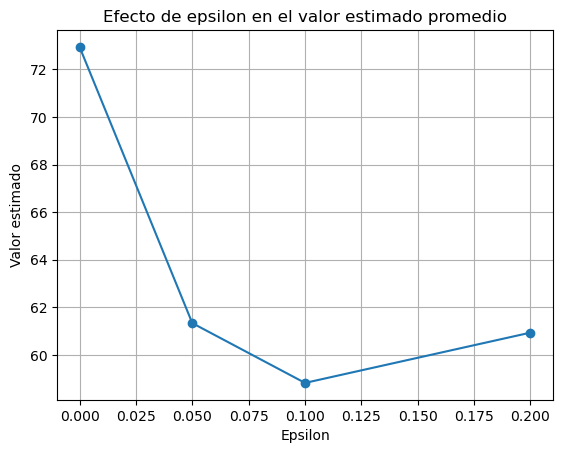

In [ ]:
env = InventoryEnvironment()

epsilons = [0.0, 0.05, 0.1, 0.2]
eps_effect = evaluate_epsilon_effect(env, epsilons)
print("Efecto de epsilon:", eps_effect)

Q_on, V_off = compare_on_off(env)
sample_state = {'product_A': 5, 'product_B': 5}
best_action = {}
for product in env.products:
    best_val = -float('inf')
    best_r = 0
    for r in range(4):
        candidate_action = {p: 0 for p in env.products}
        candidate_action[product] = r
        key = state_action_to_key(sample_state, candidate_action)
        val = Q_on.get(key, 0)
        if val > best_val:
            best_val = val
            best_r = r
    best_action[product] = best_r

print("Estado de ejemplo:", sample_state)
print("Mejor acción on-policy:", best_action)
print("Valor Q on-policy:", Q_on.get(state_action_to_key(sample_state, best_action)))
state_key = tuple(sample_state[p] for p in sorted(sample_state.keys()))
print("Valor V off-policy:", V_off.get(state_key))

plt.figure()
plt.plot(list(eps_effect.keys()), list(eps_effect.values()), marker='o')
plt.title("Efecto de epsilon en el valor estimado promedio")
plt.xlabel("Epsilon")
plt.ylabel("Valor estimado")
plt.grid(True)
plt.show()


1. ¿Cuál es el valor estimado de mantener diferentes niveles de existencias para cada producto?

Del estado de ejemplo (product_A=5, product_B=5), la mejor acción on-policy es reponer 2 de A y 3 de B, con un valor Q estimado de ~30.17, lo que indica que ese nivel de existencias intermedias y esa combinación de reposición maximizan la ganancia esperada bajo la política aprendida; en general, niveles muy bajos exigirían reposiciones mayores para capturar demanda y niveles muy altos tenderían a reducir reabastecimientos por el costo asociado.

2. ¿Cómo afecta el valor epsilon en la política blanda al rendimiento?

El valor de ε en la política blanda tiene un efecto claro: una política completamente greedy (ε=0.0) produjo el mejor valor promedio (~72.95), mientras que introducir un poco de exploración (ε=0.05–0.1) degradó el rendimiento (~61.33 y ~58.82) y solo con más exploración (ε=0.2) se ve una ligera recuperación (~60.94); en este entorno relativamente pequeño y estable, la exploración excesiva parece penalizar más que ayudar, porque la política determinista ya encuentra buenas acciones rápidamente.

3. ¿Cuál es el impacto de utilizar el aprendizaje fuera de la política en comparación con el aprendizaje dentro
de la política?

Comparando on-policy y off-policy para el mismo estado, el valor off-policy estimado (~32.11) es ligeramente mayor que el on-policy (~30.17), lo que sugiere que, con la política de comportamiento usada, la evaluación fuera de la política pudo aprovechar datos sin ejecutar directamente la política objetivo y sin desalinearse demasiado (evitando razones de importancia extremas), aunque en general off-policy con importance sampling puede incurrir en alta varianza si la política de comportamiento difiere mucho de la objetivo, mientras que on-policy es más estable al evaluar la misma política que genera los datos.